<a href="https://colab.research.google.com/github/Sulfika715/DeepLearning/blob/master/Inception_V3_Tomato_100epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import warnings
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D,Convolution2D,AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.merge import concatenate
from keras.models import Model
from keras import regularizers
from keras import initializers
from keras import backend as K
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import namedtuple
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit.annotations import Optional
from torch import Tensor


TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/'My Drive'

/content/drive/My Drive


In [0]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((299, 299))
image_size = 0
directory_root = './dataset/'
width=299
height=299
depth=3

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size,interpolation=cv2.INTER_AREA)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

    

[INFO] Loading images ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Image loading completed
CPU times: user 99 µs, sys: 29 µs, total: 128 µs
Wall time: 134 µs


In [8]:
image_size = len(image_list)
image_size

1200

In [0]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [10]:
print(label_binarizer.classes_)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
__all__ = ['Inception3', 'inception_v3', 'InceptionOutputs', '_InceptionOutputs']


model_urls = {
    # Inception v3 ported from TensorFlow
    'inception_v3_google': 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
}

InceptionOutputs = namedtuple('InceptionOutputs', ['logits', 'aux_logits'])
InceptionOutputs.__annotations__ = {'logits': torch.Tensor, 'aux_logits': Optional[torch.Tensor]}

# Script annotations failed with _GoogleNetOutputs = namedtuple ...
# _InceptionOutputs set here for backwards compat
_InceptionOutputs = InceptionOutputs


def inception_v3(pretrained=False, progress=True, **kwargs):
    r"""Inception v3 model architecture from
    `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
    .. note::
        **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
        N x 3 x 299 x 299, so ensure your images are sized accordingly.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        aux_logits (bool): If True, add an auxiliary branch that can improve training.
            Default: *True*
        transform_input (bool): If True, preprocesses the input according to the method with which it
            was trained on ImageNet. Default: *False*
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        if 'aux_logits' in kwargs:
            original_aux_logits = kwargs['aux_logits']
            kwargs['aux_logits'] = True
        else:
            original_aux_logits = True
        model = Inception3(**kwargs)
        state_dict = load_state_dict_from_url(model_urls['inception_v3_google'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        if not original_aux_logits:
            model.aux_logits = False
            del model.AuxLogits
        return model

def create_model(num_classes=1001, dropout_prob=0.2, weights=None, include_top=False):
    return inception_v3(num_classes, dropout_prob, weights, include_top)


class Inception3(nn.Module):

    def __init__(self, num_classes=1000, aux_logits=True, transform_input=False,
                 inception_blocks=None, init_weights=True):
        super(Inception3, self).__init__()
        if inception_blocks is None:
            inception_blocks = [
                BasicConv2d, InceptionA, InceptionB, InceptionC,
                InceptionD, InceptionE, InceptionAux
            ]
        assert len(inception_blocks) == 7
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]
        inception_b = inception_blocks[2]
        inception_c = inception_blocks[3]
        inception_d = inception_blocks[4]
        inception_e = inception_blocks[5]
        inception_aux = inception_blocks[6]

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
        self.Mixed_5b = inception_a(192, pool_features=32)
        self.Mixed_5c = inception_a(256, pool_features=64)
        self.Mixed_5d = inception_a(288, pool_features=64)
        self.Mixed_6a = inception_b(288)
        self.Mixed_6b = inception_c(768, channels_7x7=128)
        self.Mixed_6c = inception_c(768, channels_7x7=160)
        self.Mixed_6d = inception_c(768, channels_7x7=160)
        self.Mixed_6e = inception_c(768, channels_7x7=192)
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        self.Mixed_7a = inception_d(768)
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.fc = nn.Linear(2048, num_classes)
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    import scipy.stats as stats
                    stddev = m.stddev if hasattr(m, 'stddev') else 0.1
                    X = stats.truncnorm(-2, 2, scale=stddev)
                    values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                    values = values.view(m.weight.size())
                    with torch.no_grad():
                        m.weight.copy_(values)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _transform_input(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def _forward(self, x):
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux_defined = self.training and self.aux_logits
        if aux_defined:
            aux = self.AuxLogits(x)
        else:
            aux = None
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 2048 x 1 x 1
        x = F.dropout(x, training=self.training)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux

    @torch.jit.unused
    def eager_outputs(self, x, aux):
        # type: (Tensor, Optional[Tensor]) -> InceptionOutputs
        if self.training and self.aux_logits:
            return InceptionOutputs(x, aux)
        else:
            return x

    def forward(self, x):
        x = self._transform_input(x)
        x, aux = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted Inception3 always returns Inception3 Tuple")
            return InceptionOutputs(x, aux)
        else:
            return self.eager_outputs(x, aux)


class InceptionA(nn.Module):

    def __init__(self, in_channels, pool_features, conv_block=None):
        super(InceptionA, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = conv_block(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(self, in_channels, conv_block=None):
        super(InceptionB, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def _forward(self, x):
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(self, in_channels, channels_7x7, conv_block=None):
        super(InceptionC, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):

    def __init__(self, in_channels, conv_block=None):
        super(InceptionD, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def _forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):

    def __init__(self, in_channels, conv_block=None):
        super(InceptionE, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes, conv_block=None):
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01
        self.fc = nn.Linear(768, num_classes)
        self.fc.stddev = 0.001

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


In [15]:
base_model = InceptionV3(weights=None, include_top=False, input_tensor=Input(shape = (width, height, depth)))

x = base_model.output
output = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [16]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [17]:
#Training Model
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/100
30/30 [==============================] - 66s 2s/step - loss: 0.5704 - accuracy: 0.8319 - val_loss: 4.3668 - val_accuracy: 0.7153
Epoch 2/100
30/30 [==============================] - 36s 1s/step - loss: 0.6499 - accuracy: 0.8274 - val_loss: 4.3668 - val_accuracy: 0.7153
Epoch 3/100
30/30 [==============================] - 37s 1s/step - loss: 0.5665 - accuracy: 0.8285 - val_loss: 4.3668 - val_accuracy: 0.7153
Epoch 4/100
30/30 [==============================] - 36s 1s/step - loss: 0.5542 - accuracy: 0.8274 - val_loss: 4.3668 - val_accuracy: 0.7153
Epoch 5/100
30/30 [==============================] - 36s 1s/step - loss: 0.4251 - accuracy: 0.8398 - val_loss: 4.3668 - val_accuracy: 0.7153
Epoch 6/100
30/30 [==============================] - 36s 1s/step - loss: 0.3984 - accuracy: 0.8422 - val_loss: 4.3046 - val_accuracy: 0.7153
Epoch 7/100
30/30 [==============================] - 37s 1s

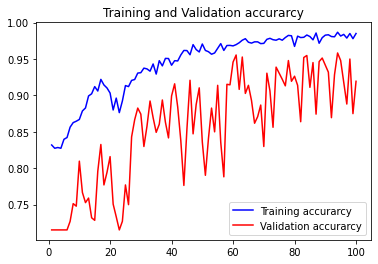

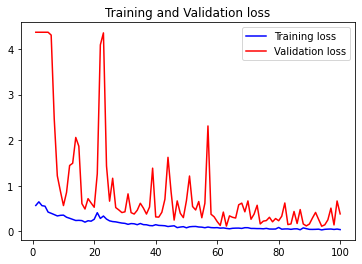

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

240/240 [==============================] - 3s 11ms/step
Test Accuracy: 91.94443821907043
